In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import json
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [2]:
path1 = '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json'
path2 = '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json'

def read_json_file(filepath):
    return pd.DataFrame.from_dict([json.loads(line) for line in open(filepath, 'r')])

df = pd.concat([read_json_file(path1), read_json_file(path2)])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [4]:
df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [5]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

embedding_dim = 100

batch_size = 200
epochs = 20

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(list(df['headline']))
sequences = tokenizer.texts_to_sequences(list(df['headline']))
word_index = tokenizer.word_index
print('There are %s unique tokens.' %len(word_index))

X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen = maxlen)
y = df['is_sarcastic']

Using TensorFlow backend.


There are 30884 unique tokens.


In [8]:
from keras.layers import Dense, Input, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras import layers

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))

model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor="val_acc", mode="max", patience=3)
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[es])

Epoch 1/20
222/222 [==============================] - 5s 25ms/step - loss: 0.4679 - accuracy: 0.7582 - val_loss: 0.2292 - val_accuracy: 0.9121
Epoch 2/20
222/222 [==============================] - 5s 24ms/step - loss: 0.1486 - accuracy: 0.9490 - val_loss: 0.0928 - val_accuracy: 0.9689
Epoch 3/20
222/222 [==============================] - 5s 24ms/step - loss: 0.0371 - accuracy: 0.9891 - val_loss: 0.0512 - val_accuracy: 0.9865
Epoch 4/20
222/222 [==============================] - 5s 24ms/step - loss: 0.0089 - accuracy: 0.9976 - val_loss: 0.0592 - val_accuracy: 0.9892
Epoch 5/20
222/222 [==============================] - 5s 24ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0556 - val_accuracy: 0.9904
Epoch 6/20
222/222 [==============================] - 6s 25ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0838 - val_accuracy: 0.9879
Epoch 7/20
222/222 [==============================] - 5s 24ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0644 - val_accuracy: 0.9904

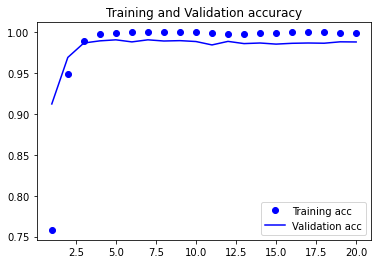

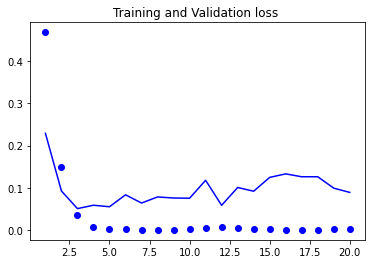

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss ')
plt.show()